# I will use the distorted model by Bianca to test my method of deriving the distortion coefficient in HRT calibration data



In [1]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick
from skimage import measure
import skimage
import pandas as pd
#%matplotlib inline

In [2]:
path = '/home/fatima/Desktop/solar_orbiter_project/ZEMAX/'

In [3]:
'''
F =open(path+'copy.txt','r')
F2 = open(path+'Model','w')
for line in F:
    line = line.split('%')[0]
    F2.write(line+'\n')
F2.close()
#F = pd.read_csv(path+'copy.txt')
'''

"\nF =open(path+'copy.txt','r')\nF2 = open(path+'Model','w')\nfor line in F:\n    line = line.split('%')[0]\n    F2.write(line+'\n')\nF2.close()\n#F = pd.read_csv(path+'copy.txt')\n"

In [4]:
f = np.loadtxt(path+'Model')
i = f[:,0]; j = f[:,1]; xfield = f[:,2]; yfield = f[:,3]; R = f[:,4]; xinput = f[:,5]; yinput=f[:,6]; xoutput = f[:,7]; youtput = f[:,8]; distortion = f[:,9]

In [5]:
print i.shape #101 pixels in x and 101 pixels in y : 101x101, center is at (50.5,50.5)
print xinput[5100]
print xoutput[5100]

(10201,)
0.0
0.0


In [9]:
print abs(distortion).min()
print abs(distortion).max()
print np.where(abs(distortion) ==abs(distortion).max() )
distortion[5100]

0.0
1.403359
(array([0]),)


0.0

In [10]:
Routput = np.sqrt((xoutput)**2+(youtput)**2)
Rinput = np.sqrt((xinput)**2+(yinput)**2)
print Routput[0] - Rinput[0]
Routput = np.delete(Routput,[5100])
Rinput = np.delete(Rinput,[5100])
d=(((Routput-Rinput)/Routput)*100)
print d.mean()
print distortion.mean()
print np.abs(distortion).max()


-0.182812896521
-0.431518537766
-0.431406035193
1.403359


In [11]:
## RMS error:
np.sqrt((1./len(xinput))*np.sum((xinput-xoutput)**2+(yinput-youtput)**2))

0.050716847384421677

In [16]:
np.abs(Routput-Rinput).max()

0.18281289652107979

# The initial grid

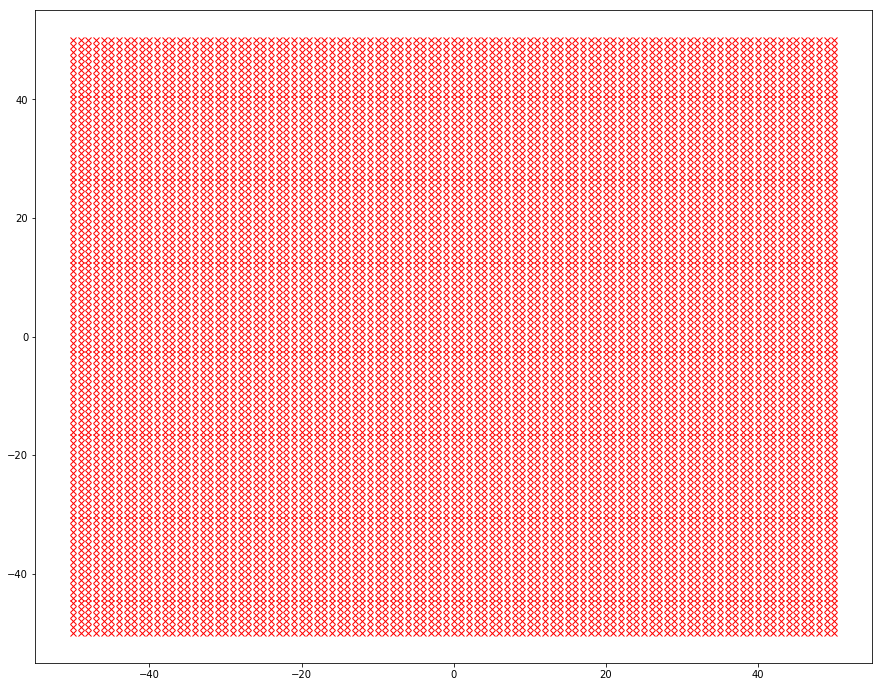

In [7]:
plt.ion()
fig = plt.figure(figsize=(15,12))
plt.plot(i,j,'rx')
#plt.savefig('grid_zemax.png',dpi=300)

# The position of field points with and without distortion

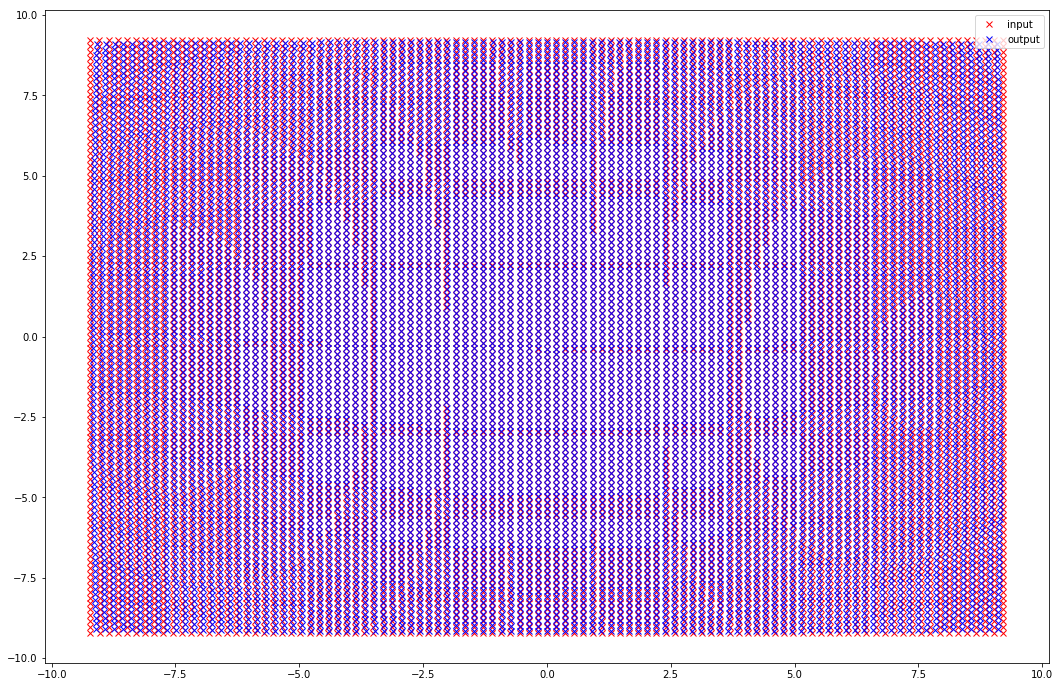

In [8]:
fig = plt.figure(figsize=(18,12))
plt.plot(xinput,yinput,'rx',label='input')
plt.plot(xoutput,youtput,'bx',label='output')
plt.legend()
plt.savefig('input_output.png',dpi=300)

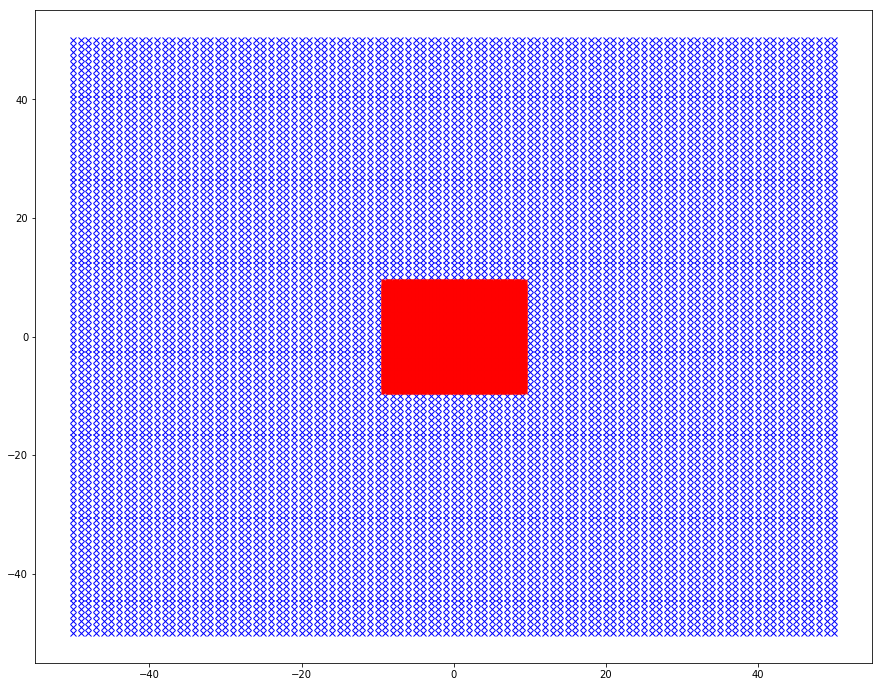

In [9]:
plt.clf()
fig = plt.figure(figsize=(15,12))
plt.plot(i,j,'bx',label='initial grid')

plt.plot(xinput,yinput,'rx',label='output')


In [10]:
(xoutput.max()-xoutput.min())/101

0.18139742574257425

# As shown, the distortion is Barrel where points are pulled inwards.

In [11]:
distortion #the percentage of distortion

array([-1.403359, -1.373412, -1.344154, ..., -1.240349, -1.26947 ,
       -1.299366])

In [57]:
f = np.loadtxt(path+'Model')
i = f[:,0]; j = f[:,1]; xfield = f[:,2]; yfield = f[:,3]; R = f[:,4]; xinput = f[:,5]; yinput=f[:,6]; xoutput = f[:,7]; youtput = f[:,8]; distortion = f[:,9]

In [58]:
# the distance from each point (in input and output maps) to the center of the image (distortion)
xinput=np.delete(xinput,[5100,5100])
yinput = np.delete(yinput,[5100,5100])
xoutput = np.delete(xoutput, [5100,5100])
youtput = np.delete(youtput, [5100,5100])

In [69]:
R=np.sqrt((xoutput-xinput)**2+(youtput-yinput)**2)
np.where(R==R.max())
R[0]
distortion[0]

-1.403359

In [15]:
xinput=np.delete(xinput,[5100,5100])
yinput = np.delete(yinput,[5100,5100])
xoutput = np.delete(xoutput, [5100,5100])
youtput = np.delete(youtput, [5100,5100])
Dinput= np.sqrt(xinput**2+yinput**2)
Doutput = np.sqrt(xoutput**2+youtput**2)

In [16]:
100*(Doutput-Dinput)/Dinput

array([-1.40227205, -1.37229606, -1.34298691, ..., -1.23802454,
       -1.26725868, -1.29720673])

# Saving the data points into lines and columns

In [17]:
f = np.loadtxt(path+'Model')
i = f[:,0]; j = f[:,1]; xfield = f[:,2]; yfield = f[:,3]; R = f[:,4]; xinput = f[:,5]; yinput=f[:,6]; xoutput = f[:,7]; youtput = f[:,8]; distortion = f[:,9]

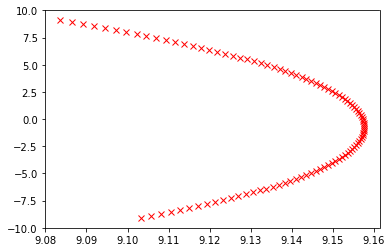

In [18]:
ind = np.where(i==-50)
plt.plot(xoutput[ind], youtput[ind],'rx')
plt.show()

In [19]:
LINES = []
COLUMNS=[]

In [20]:
'''
i = 1
for n in range(1,102):
    LINES.append(np.array([xoutput[i:101*n],youtput[i:101*n]]))
    i = 101*n
'''
#OR
for n in np.linspace(-50,50,101):
    ind = np.where(j==n)
    LINES.append([xoutput[ind],youtput[ind]])

In [21]:
for n in np.linspace(-50,50,101):
    ind = np.where(i==n)
    COLUMNS.append(np.array([xoutput[ind],youtput[ind]]))

# Fitting parabolas

In [22]:
def parabola_lines(x,a,b,c):
    y = a*x**2 + b*x + c
    return y
def parabola_columns(y,m,n,p):
    x = m*y**2 + n*y + p
    return x


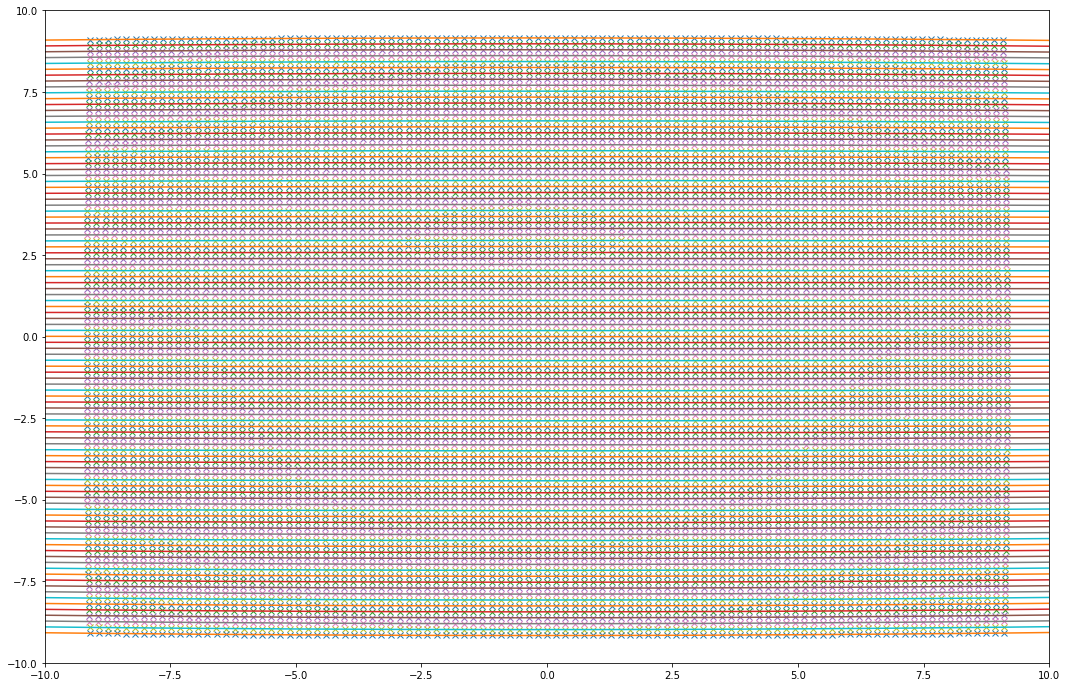

In [23]:
plt.ioff()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0
A = np.zeros(len(LINES))
B = np.zeros(len(LINES))
C = np.zeros(len(LINES))
for line in LINES:
    x = line[0]; y = line[1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)   ## estimating the guess array for each line
    popt, pcov = curve_fit(parabola_lines, x,y,p0)
     ## GOODNESS OF FIT
    chi_sq_w_lines = np.sum((parabola_lines(x,*popt)-y)**2)
    red_chi_sq_lines = chi_sq_w_lines/(len(x)-len(popt))
    #print chi_sq_w_lines, red_chi_sq_lines
    A[n] = popt[0]; B[n] = popt[1]; C[n] = popt[2]
    xnew = np.linspace(-50, 50, 1000)
    ynew = parabola_lines(xnew, *popt)
    ax.plot(x,y,'x')
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    
    n=n+1

#plt.legend()
plt.savefig('parabolas_zemax.png',dpi=300)
plt.show()

1.24272901317e-05 1.26809082976e-07
1.19056757928e-05 1.21486487681e-07
1.14335541279e-05 1.16668919672e-07
1.09870757669e-05 1.1211301803e-07
1.0551834596e-05 1.07671781591e-07
1.01193499112e-05 1.03258672563e-07
9.68750166475e-06 9.88520578035e-08
9.28913805591e-06 9.47871230195e-08
8.89017742816e-06 9.07160962057e-08
8.52628397591e-06 8.70028977134e-08
8.15291958841e-06 8.31930570246e-08
7.77949104428e-06 7.93825616763e-08
7.47608093949e-06 7.62865401988e-08
7.16107192461e-06 7.3072162496e-08
6.80177023308e-06 6.94058187049e-08
6.48318474923e-06 6.61549464207e-08
6.16190443045e-06 6.28765758209e-08
5.85954995469e-06 5.97913260683e-08
5.59216035377e-06 5.70628607528e-08
5.29071105329e-06 5.39868474826e-08
5.03467585894e-06 5.13742434586e-08
4.7586473879e-06 4.85576264071e-08
4.518845091e-06 4.61106641939e-08
4.27519778601e-06 4.36244672042e-08
3.99513157781e-06 4.07666487531e-08
3.78216521078e-06 3.8593522559e-08
3.54130587346e-06 3.6135774219e-08
3.31661608978e-06 3.38430213242e-08


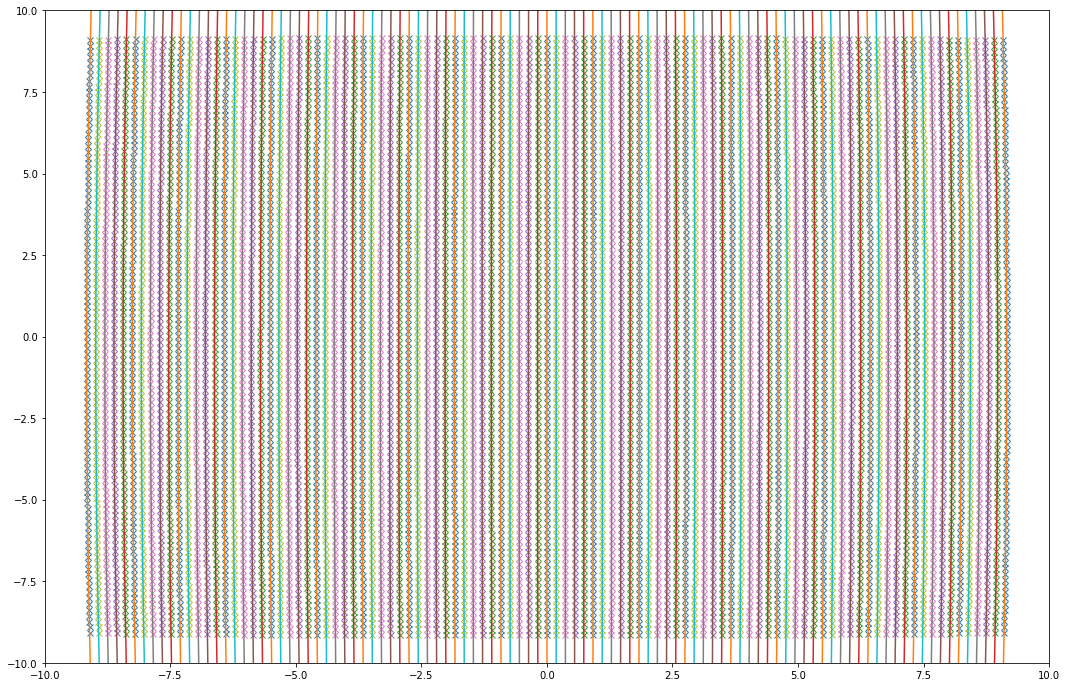

In [24]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0
M = np.zeros(len(COLUMNS))
N =  np.zeros(len(COLUMNS))
P =  np.zeros(len(COLUMNS))
for col in COLUMNS:
    x = col[0]; y = col[1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)
    popt, pcov = curve_fit(parabola_columns, y,x,p0)
    chi_sq_w_cols = np.sum((parabola_columns(y,*popt)-x)**2)
    red_chi_sq_cols = chi_sq_w_cols/(len(x)-len(popt))
    print chi_sq_w_cols ,red_chi_sq_cols

    
    M[n]=popt[0]; N[n] = popt[1]; P[n] = popt[2]
    ynew = np.linspace(-10, 10, 10000)
    xnew = parabola_columns(ynew, *popt)
    ax.plot(x,y,'x')
    ax.plot(xnew, ynew,label=str(n))
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    n=n+1

#plt.legend()
plt.savefig('parabolas_zemax_cols.png',dpi=300)
plt.show()

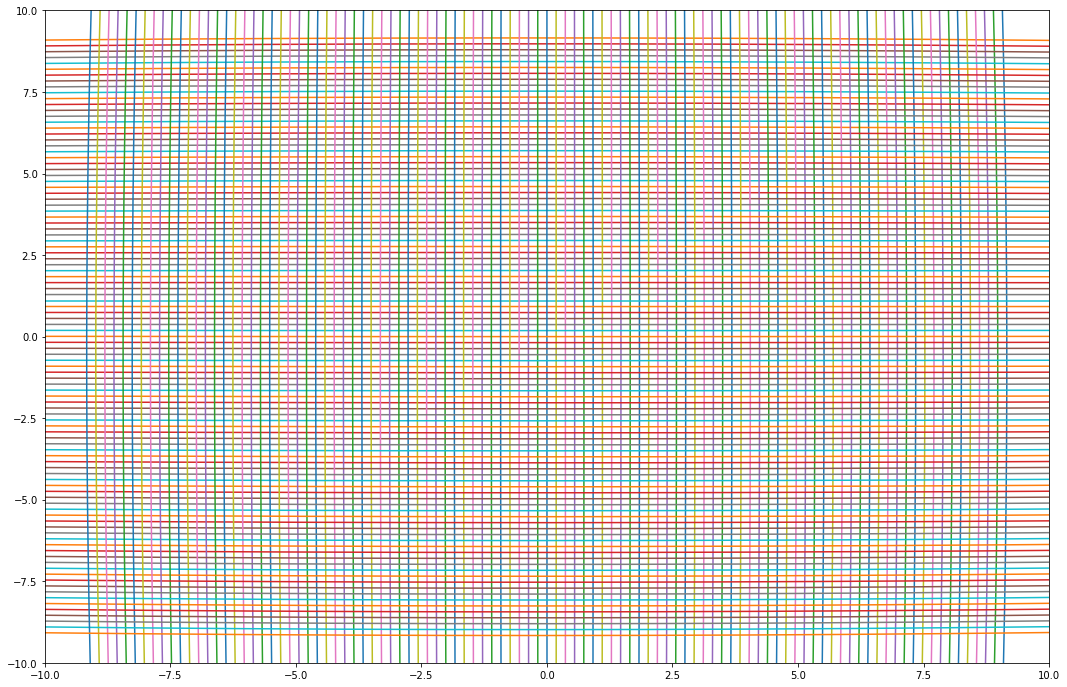

In [26]:
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0
M = np.zeros(len(COLUMNS))
N =  np.zeros(len(COLUMNS))
P =  np.zeros(len(COLUMNS))
for col,line in zip(COLUMNS,LINES):
    x = col[0]; y = col[1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)
    popt, pcov = curve_fit(parabola_columns, y,x,p0)
    
    
    M[n]=popt[0]; N[n] = popt[1]; P[n] = popt[2]
    ynew = np.linspace(-10, 10, 10000)
    xnew = parabola_columns(ynew, *popt)
    #ax.plot(x,y,'x')
    ax.plot(xnew, ynew,label=str(n))
    
    x = line[0]; y = line[1]
    temp1 = np.array([[x[0]**2,x[1]**2,x[2]**2], [x[0],x[1],x[2]],[1,1,1]])
    temp2 = np.array([y[0], y[1],y[2]])
    p0 = np.linalg.solve(temp1,temp2)   ## estimating the guess array for each line
    popt, pcov = curve_fit(parabola_lines, x,y,p0)
     ## GOODNESS OF FIT
    
    A[n] = popt[0]; B[n] = popt[1]; C[n] = popt[2]
    xnew2 = np.linspace(-10, 10, 1000)
    ynew2 = parabola_lines(xnew2, *popt)
    #ax.plot(x,y,'x')
    ax.plot(xnew2, ynew2,label=str(n))
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    
    n=n+1
#plt.legend()
#plt.savefig('zemax_distorted.png',dpi=300)
plt.show()

[  8.75851522e-04   3.64312262e-04  -9.16322878e+00]


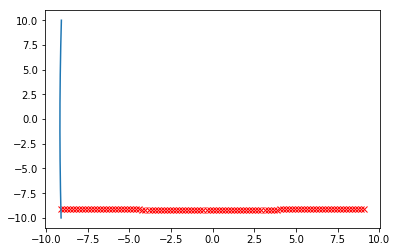

In [27]:
plt.clf()
plt.plot(x,y,'rx')
plt.plot(xnew,ynew)
print popt

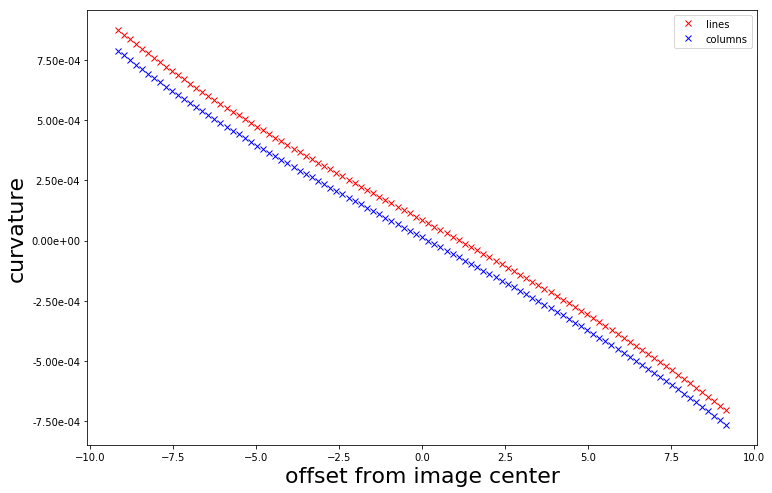

In [28]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(C,A,'rx',label='lines')
ax.plot(P,M,'bx',label='columns')
ax.set_xlabel('offset from image center',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')
plt.show()


1.94599793514e-05 1.96565447994e-07
1.88127766075e-05 1.9002804654e-07


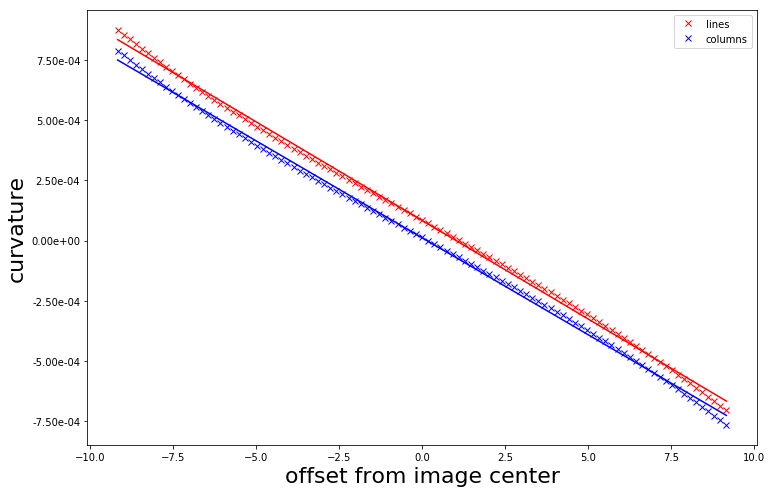

In [29]:
## lines
t = np.polyfit(C, A, 1)
tnew = np.linspace(C.min(),C.max(),100)
model = np.poly1d(t)
Tnew = model(tnew)
## GOODNESS OF FIT
chi_sq_w_lines = np.sum((model(A)-A)**2)
red_chi_sq_lines = chi_sq_w_lines/(len(A)-len(t))

print chi_sq_w_lines,red_chi_sq_lines
## columns
t2 = np.polyfit(P, M, 1)
tnew2 = np.linspace(P.min(),P.max(),100)
model2 = np.poly1d(t2)
Tnew2 = model2(tnew2)

## goodness of fit
chi_sq_w_cols = np.sum((model2(M)-M)**2)
red_chi_sq_cols = chi_sq_w_cols/(len(M)-len(t2))
print chi_sq_w_cols ,red_chi_sq_cols

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(C,A,'rx',label='lines')
ax.plot(tnew,Tnew,'r')
ax.plot(P,M,'bx',label='columns')
ax.plot(tnew2, Tnew2, 'b')
ax.set_xlabel('offset from image center',fontsize=22)
ax.set_ylabel('curvature',fontsize=22)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.legend(loc='best')
#plt.savefig('cvso_zemax.png',dpi=300)

In [30]:
Ny= Nx = 20
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
xc = center[1]
yc = center[0]
del_lines = -t[1]/t[0]
del_columns = -t2[1]/t2[0]
y_d = del_lines+yc
x_d = del_columns + xc
print 'the distortion center for python ROF is:', (x_d,y_d)
print xc, yc
del_lines, del_columns

the distortion center for python ROF is: (9.6489474608736749, 10.526013385429158)
9.5 9.5


(1.0260133854291573, 0.14894746087367455)

# Refining the distortion center position

In [31]:
Ny= Nx = 20
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
xd = center[1]
yd = center[0]
C_2 = A*xc**2 + B*xc + C - yd #lines
P_2 = M*yc**2 + N*yc + P - xd #columns
trials = 10
i=0
temp_x = temp_y = np.zeros((10))


In [32]:
for n in range(trials):
    
    t = np.polyfit(C_2, A, 1)
    t2 = np.polyfit(P_2, M, 1)
    
    del_lines = -t[1]/t[0]
    del_columns = -t2[1]/t2[0]
    yd = del_lines+yd
    xd = del_columns + xd
    print 'the distortion center is:', (xd,yd)
    print del_lines, del_columns
   
    C_2 = A*x_d**2 + B*x_d + C - yd#lines
    P_2 = M*y_d**2 + N*y_d + P - xd #columns
    temp_x[i] = xd
    temp_y[i] = yd
    i=i+1

the distortion center is: (0.14816159670835916, 1.0250273676798329)
-8.47497263232 -9.35183840329
the distortion center is: (0.14807689567625207, 1.0250120679293657)
-1.52997504673e-05 -8.47010321071e-05
the distortion center is: (0.14807689567625251, 1.0250120679293657)
-9.24689529423e-17 4.35308152823e-16
the distortion center is: (0.14807689567625273, 1.0250120679293657)
-9.24689529423e-17 2.15598484187e-16
the distortion center is: (0.14807689567625307, 1.0250120679293657)
-9.24689529423e-17 3.29707116844e-16
the distortion center is: (0.1480768956762534, 1.0250120679293657)
-9.24689529423e-17 3.29707116844e-16
the distortion center is: (0.14807689567625276, 1.0250120679293657)
-9.24689529423e-17 -6.28501743726e-16
the distortion center is: (0.1480768956762531, 1.0250120679293657)
-9.24689529423e-17 3.29707116844e-16
the distortion center is: (0.14807689567625343, 1.0250120679293657)
-9.24689529423e-17 3.29707116844e-16
the distortion center is: (0.14807689567625279, 1.025012067929

In [33]:
x_d = xd
y_d = yd
C_3 = A*x_d**2 + B*x_d + C - y_d
P_3 = M*y_d**2 + N*y_d + P - x_d
B_3 = 2*A*x_d + B
N_3 = 2*M*y_d + N

[  8.81011703e-05   8.75748193e-05   8.70565721e-05   8.65465871e-05
   8.60472517e-05   8.55568309e-05   8.50759297e-05   8.46038075e-05
   8.41380763e-05   8.36804898e-05   8.32308161e-05   8.27886207e-05
   8.23549787e-05   8.19247077e-05   8.15067643e-05   8.10950082e-05
   8.06854936e-05   8.02843298e-05   7.98858271e-05   7.94935584e-05
   7.91007911e-05   7.87200355e-05   7.83319782e-05   7.79549803e-05
   7.75677426e-05   7.71871122e-05   7.67970272e-05   7.64047662e-05
   7.60127005e-05   7.56010770e-05   7.51745204e-05   7.47288572e-05
   7.42668154e-05   7.37495531e-05   7.31939973e-05   7.25643003e-05
   7.18660762e-05   7.09911067e-05   6.99157593e-05   6.85261839e-05
   6.65821331e-05   6.35777031e-05   5.82082787e-05   4.57263351e-05
  -2.32818142e-05   1.54180881e-04   1.03891650e-04   9.28439948e-05
   8.79711471e-05   8.52217616e-05   8.34494589e-05   8.22158904e-05
   8.13069804e-05   8.06137115e-05   8.00722292e-05   7.96422658e-05
   7.93018002e-05   7.90247118e-05

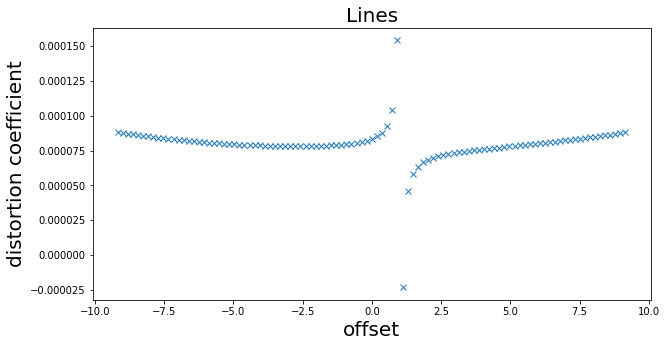

In [34]:
k_lines = (-A)/(C_3*(3*A*C_3 + 3*B_3**2 + 1))
plt.figure(figsize=(10,5))
plt.plot(C, k_lines,'x')
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Lines',fontsize=20)
print k_lines
print k_lines.mean()
print np.average(k_lines,weights=np.abs(C))

In [35]:
'''
ind = np.where(k_lines==k_lines.min())
ind=ind[0][0]
Ind = np.arange(ind-1,ind+1,1)

k_lines_2 = np.delete(k_lines,[Ind])
C_2 = np.delete(C_3,[Ind])
'''

'\nind = np.where(k_lines==k_lines.min())\nind=ind[0][0]\nInd = np.arange(ind-1,ind+1,1)\n\nk_lines_2 = np.delete(k_lines,[Ind])\nC_2 = np.delete(C_3,[Ind])\n'

In [36]:
'''
plt.figure(figsize=(10,5))
plt.plot(C_2, k_lines_2,'x')
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Lines',fontsize=20)
print k_lines_2
print k_lines_2.mean()
print np.average(k_lines_2,weights=np.abs(C_2))
'''

"\nplt.figure(figsize=(10,5))\nplt.plot(C_2, k_lines_2,'x')\nplt.ylabel('distortion coefficient',fontsize=20)\nplt.xlabel('offset',fontsize=20)\nplt.title('Lines',fontsize=20)\nprint k_lines_2\nprint k_lines_2.mean()\nprint np.average(k_lines_2,weights=np.abs(C_2))\n"

[  8.67750875e-05   8.62431953e-05   8.57283338e-05   8.52234607e-05
   8.47306801e-05   8.42508502e-05   8.37826271e-05   8.33251464e-05
   8.28820542e-05   8.24482094e-05   8.20243735e-05   8.16118377e-05
   8.12108310e-05   8.08194130e-05   8.04352434e-05   8.00606105e-05
   7.97002492e-05   7.93526596e-05   7.90070469e-05   7.86737713e-05
   7.83507650e-05   7.80400153e-05   7.77273963e-05   7.74344860e-05
   7.71497807e-05   7.68644079e-05   7.65910581e-05   7.63290353e-05
   7.60654604e-05   7.58267147e-05   7.55770380e-05   7.53459140e-05
   7.51041860e-05   7.48831517e-05   7.46553970e-05   7.44307606e-05
   7.42075404e-05   7.39872110e-05   7.37539476e-05   7.35228817e-05
   7.32641585e-05   7.29789570e-05   7.26568850e-05   7.22746305e-05
   7.18044739e-05   7.11349249e-05   7.01049041e-05   6.81997727e-05
   6.31930824e-05   7.75600199e-06   9.02597222e-05   8.12530850e-05
   7.86752286e-05   7.74591754e-05   7.67632916e-05   7.63226216e-05
   7.60283447e-05   7.58216139e-05

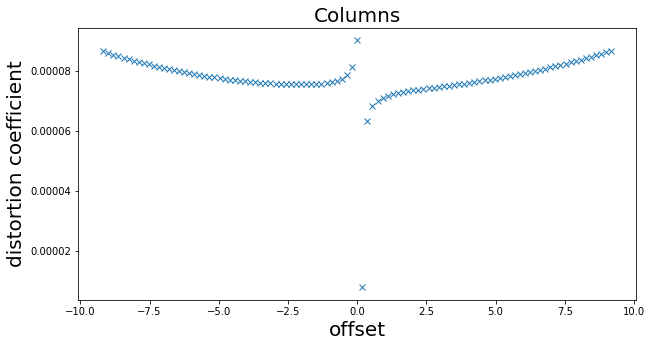

In [37]:
plt.figure(figsize=(10,5))
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Columns',fontsize=20)
k_cols = (-M)/(P_3*(3*M*P_3+ 3*N_3**2 + 1))
print k_cols
plt.plot(P,k_cols,'x')
print k_cols.mean()
print np.average(k_cols,weights=np.abs(P))

In [38]:
'''
ind = np.where(k_cols==k_cols.min())
ind=ind[0][0]
Ind = np.arange(ind-5,ind+5,1)
print Ind
k_cols_2 = np.delete(k_lines,Ind)
P_2 = np.delete(P_3,[Ind])
print k_cols_2.mean()
print np.average(k_cols_2,weights=np.abs(P_3))
'''


'\nind = np.where(k_cols==k_cols.min())\nind=ind[0][0]\nInd = np.arange(ind-5,ind+5,1)\nprint Ind\nk_cols_2 = np.delete(k_lines,Ind)\nP_2 = np.delete(P_3,[Ind])\nprint k_cols_2.mean()\nprint np.average(k_cols_2,weights=np.abs(P_3))\n'

In [39]:
'''
plt.figure(figsize=(10,5))
plt.ylabel('distortion coefficient',fontsize=20)
plt.xlabel('offset',fontsize=20)
plt.title('Columns',fontsize=20)
plt.plot(P_2,k_cols_2,'x')
'''

"\nplt.figure(figsize=(10,5))\nplt.ylabel('distortion coefficient',fontsize=20)\nplt.xlabel('offset',fontsize=20)\nplt.title('Columns',fontsize=20)\nplt.plot(P_2,k_cols_2,'x')\n"

In [128]:
K = np.array([np.average(k_lines, weights=np.abs(C_3)), np.average(k_cols, weights=np.abs(P_3))])
#K2 =  np.array([np.average(k_lines, weights=C), np.average(k_cols, weights=P)])
#print K.mean()
#print K2.mean()
#K = np.array(k_lines_2.mean(),k_cols_2.mean())
print K.mean()/10000  ## in pixels

8.10966201269e-09


In [41]:
k =K.mean()
print k
f = np.loadtxt(path+'Model')
i = f[:,0]; j = f[:,1]; xfield = f[:,2]; yfield = f[:,3]; R = f[:,4]; xinput = f[:,5]; yinput=f[:,6]; xoutput = f[:,7]; youtput = f[:,8]; distortion = f[:,9]
X_d = xoutput; Y_d = youtput; y_d=x_d=0
X_u = X_d + (X_d - x_d )*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))
Y_u = Y_d + (Y_d - y_d)*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))


8.10966201269e-05


In [42]:
## how much the undistorted resemble the input:
print np.sum((X_u-xinput)**2)/np.sum(xinput**2)


5.65699864545e-07


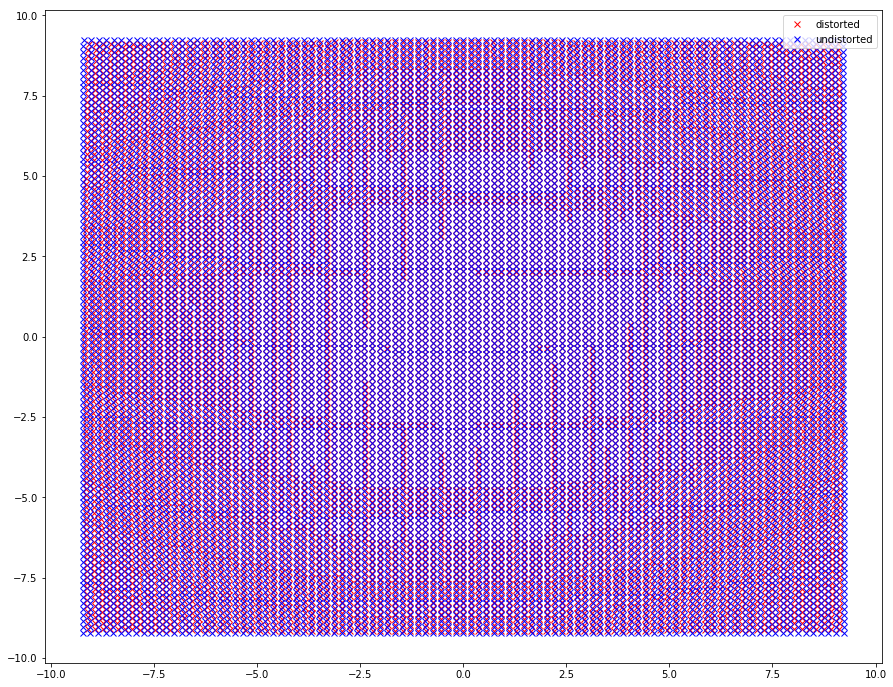

In [43]:
fig = plt.figure(figsize=(15,12))
plt.plot(xoutput,youtput,'rx',label='distorted')
#plt.plot(xinput, yinput,'rx',label='input')
plt.plot(X_u,Y_u,'bx',label='undistorted')
plt.legend()
plt.savefig('d_u_zemax.png',dpi=300)

In [44]:
plate_scale = 0.5
d_m_pixels = 100*np.sqrt((1./len(X_u))*np.sum((X_u-X_d)**2+(Y_u-Y_d)**2))
d_m_arc = d_m_pixels*plate_scale
d_m_km = d_m_arc*725
print "the distortion is around:",'\n', d_m_pixels, 'pixels', '\n', d_m_arc, 'arcseconds', '\n',d_m_km, 'km'

the distortion is around: 
5.28876444842 pixels 
2.64438222421 arcseconds 
1917.17711255 km


In [47]:
# disortionpercent:
#xinput=np.delete(xinput,[5100,5100])
#yinput = np.delete(yinput,[5100,5100])
X_d = np.delete(xoutput, [5100,5100])
Y_d = np.delete(youtput, [5100,5100])
X_u = X_d + (X_d - x_d )*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))
Y_u = Y_d + (Y_d - y_d)*(k*((X_d-x_d)**2 + (Y_d-y_d)**2))

D=((np.sqrt((X_d-x_d)**2+(Y_d-y_d)**2) - np.sqrt((X_u-x_d)**2+(Y_u-y_d)**2))/np.sqrt((X_u-x_d)**2+(Y_u-y_d)**2))*100
print D.mean()


-0.460069756871
1.3250060264


In [74]:
R=np.sqrt((X_u-X_d)**2+(Y_u-Y_d)**2)
R.max()
np.where(R==R.max())
D[10199]

-1.3250060263951808

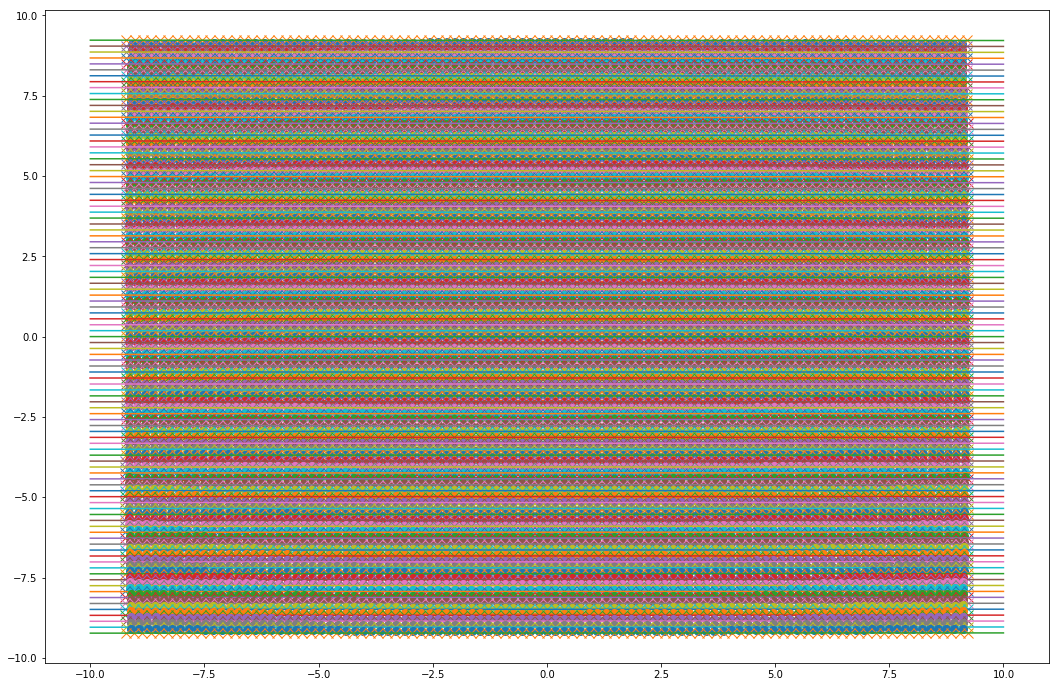

In [149]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0

for line in LINES:
    X_d = line[0] -x_d  
    Y_d = line[1] -y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2))
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2))
    params = np.array([B[n]*(3*k*C[n]**2 +1), C[n]*(k*C[n]**2+1)])
    xnew = np.linspace(-10, 10, 100)
    ynew = params[0]*xnew + params[1]
    ax.plot(X_d,Y_d,'o',markersize=8,label='distorted')
    ax.plot(X_u,Y_u,'x',markersize=10,label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    #ax.set_xlim(-2000,2400)
    #ax.set_ylim(80-y_d,1800-y_d)
    n=n+1

#plt.legend()
plt.show()

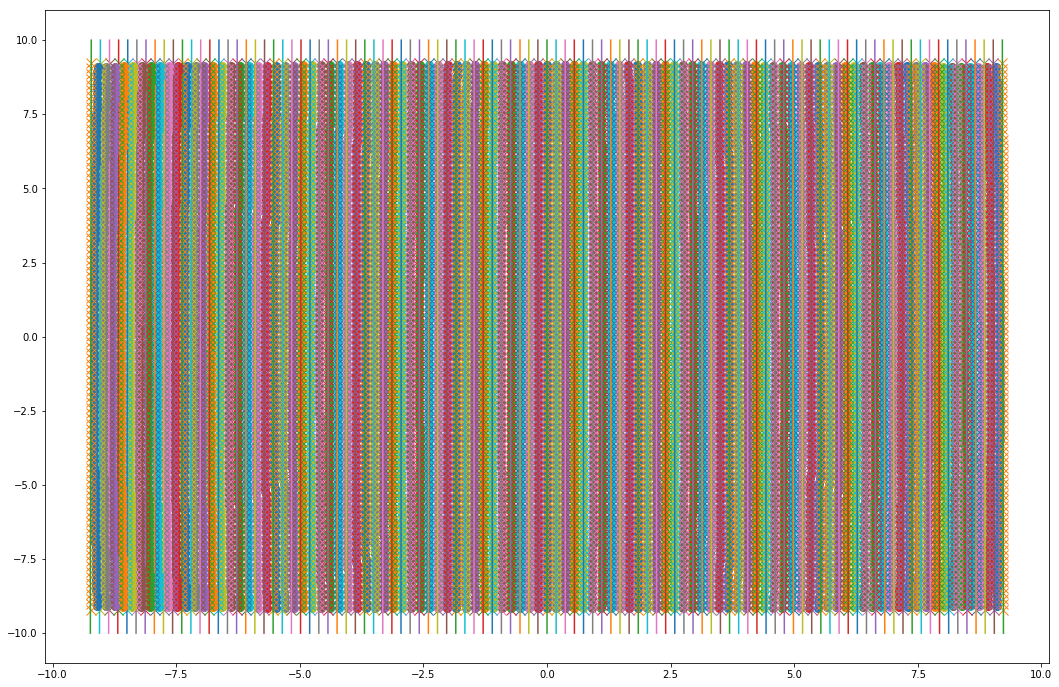

In [150]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
n=0

for col in COLUMNS:
    X_d = col[0] - x_d
    Y_d = col[1] - y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2)) 
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2)) 
    params = np.array([N[n]*(3*k*P[n]**2 +1), P[n]*(k*P[n]**2+1)])
    ynew = np.linspace(-10,10, 100)
    xnew = params[0]*ynew + params[1]    
    ax.plot(X_d,Y_d,'o',markersize=8,label='distorted')
    ax.plot(X_u,Y_u,'x', markersize=10,label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    #ax.set_xlim(-1000,1000)
    #ax.set_ylim(-1800,2400)
    n=n+1

#plt.legend()
plt.show()


# We can conclude since my radial model has returned the same percent of distortion as the one from the ZEMAX, that my method of estimating the distortion coefficient is valid.

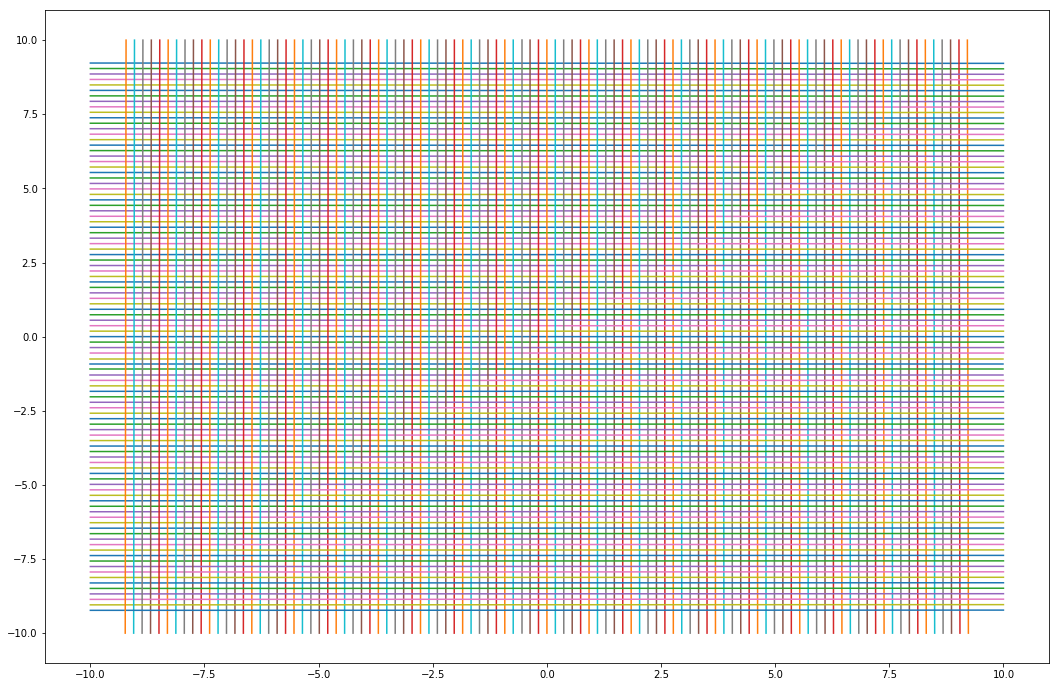

In [172]:
plt.clf()
fig=plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)

n=0
for line in LINES or col in COLUMNS:
    X_d = line[0] -x_d  
    Y_d = line[1] -y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2))
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2))
    params = np.array([B[n]*(3*k*C[n]**2 +1), C[n]*(k*C[n]**2+1)])
    xnew = np.linspace(-10, 10, 100)
    ynew = params[0]*xnew + params[1]
    #ax.plot(X_d,Y_d,'o',markersize=8,label='distorted')
    #ax.plot(X_u,Y_u,'x',markersize=10,label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    
    X_d = col[0] - x_d
    Y_d = col[1] - y_d
    X_u = X_d + (X_d)*(k*((X_d)**2 + (Y_d)**2)) 
    Y_u = Y_d + (Y_d )*(k*((X_d)**2 + (Y_d)**2)) 
    params = np.array([N[n]*(3*k*P[n]**2 +1), P[n]*(k*P[n]**2+1)])
    ynew = np.linspace(-10,10, 100)
    xnew = params[0]*ynew + params[1]    
    #ax.plot(X_d,Y_d,'o',markersize=8,label='distorted')
    #ax.plot(X_u,Y_u,'x', markersize=10,label='undistorted')
    ax.plot(xnew, ynew,label='straight')
    n=n+1

#plt.legend()
plt.savefig('final_zemax.png',dpi=300)
plt.show()